In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from keras.optimizers import adam, RMSprop
from keras.models import load_model
from data_preparation import StockIndexDataset
from rnn_models import (build_SimpleRNN, build_GRU, build_LSTM, 
                       training_callbacks, ModelPredictions,
                       rmse, mda)
from utils_rnn import plot_seqs, create_labels

Using TensorFlow backend.


In [2]:
# Set constant variables and hyper-parameters for the model training

INPUT_PATH = "/kaggle/input/sh300if"  # OUTPUT_PATH = "/kaggle/output"  

RNN_params = {"batch_size": 32,
              "epochs": 60,
              "lr": 1e-4,
              "time_steps": 12,
              "forecast_steps": 6,
              "window": 12,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

GRU_params = {"batch_size": 32,
              "epochs": 60,
              "lr": 1e-4,
              "time_steps": 6,
              "forecast_steps": 6,
              "window": 12,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

LSTM_params = {"batch_size": 32,
               "epochs": 60,
               "lr": 1e-4,
               "time_steps": 6,
               "forecast_steps": 6,
               "window": 12,
               "RNN_size": 128,
               "FC_size": 32,
               "optim": adam,
               "dropout": 0.5,
               "earlystop": {"patience": 20, 
                             "min_delta": 0.00001},
               "reduce_lr": {"factor": 0.1,
                             "patience": 10,
                             "min_delta": 0.0001}
               }

In [3]:
# Load datasets
datasets_path = [os.path.join(INPUT_PATH, file) for file in sorted(os.listdir(INPUT_PATH))]
for p in datasets_path:
    print(p)

/kaggle/input/sh300if/2010.4.1-2012.12.31.txt
/kaggle/input/sh300if/2013-2015.txt
/kaggle/input/sh300if/2015-2017.txt
/kaggle/input/sh300if/2017-2019.4.29.txt


In [4]:
# Create a StockIndexDataset object for the SimpleRNN network
RNNdata = StockIndexDataset(datasets_path[0], time_steps=RNN_params['time_steps'], 
                            forecast_steps=RNN_params['forecast_steps'],
                            batch_size=RNN_params['batch_size'], val_ratio=.1, test_ratio=0.1)
RNNdata.info()

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200


In [5]:
# Create a StockIndexDataset object for the GRU network
GRUdata = StockIndexDataset(datasets_path[2:], time_steps=GRU_params['time_steps'],
                            forecast_steps=GRU_params['forecast_steps'],
                            batch_size=GRU_params['batch_size'], val_ratio=.1, test_ratio=.1)
GRUdata.info()

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 40832
Validation Set Length: 4512
Test Set Length: 5024


In [6]:
# Create a StockIndexDataset object for the LSTM network
LSTMdata = StockIndexDataset(datasets_path[2:], time_steps=LSTM_params['time_steps'],
                             forecast_steps=LSTM_params['forecast_steps'],
                             batch_size=LSTM_params['batch_size'], val_ratio=.1, test_ratio=.1)
LSTMdata.info()

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 40832
Validation Set Length: 4512
Test Set Length: 5024


In [7]:
# Build the Simple RNN network
RNN_input = (RNNdata.batch_size, RNNdata.time_steps, RNNdata.X_train.shape[2])
RNN_model = build_SimpleRNN(RNN_input, RNN_params)

# Define callbacks for later model training
# Add 'mcp' keyword into the "callbacks" list for 
# saving the best weights during model traning

OUTPUT_PATH = "RNN_bestweights.hdf5"  
# change to your own working directory for a specific model
output_dir = os.path.dirname(OUTPUT_PATH)
callbacks = training_callbacks(['reduce_lr', 'mcp'], params = RNN_params,
                               filepath = OUTPUT_PATH)

In [8]:
# Build the Rnn network with GRU units
GRU_input = (GRUdata.batch_size, GRUdata.time_steps, GRUdata.X_train.shape[2])
GRU_model = build_GRU(GRU_input, GRU_params)

In [9]:
# Build the Rnn network with LSTM units
LSTM_input = (LSTMdata.batch_size, LSTMdata.time_steps, LSTMdata.X_train.shape[2])
LSTM_model = build_LSTM(LSTM_input, LSTM_params)

In [10]:
%%time
# Train Simple RNN model
RNN_hist = RNN_model.fit(RNNdata.X_train, RNNdata.y_train, 
                         epochs=RNN_params["epochs"], batch_size=RNNdata.batch_size,
                         shuffle=False, validation_data=(RNNdata.X_val, RNNdata.y_val), 
                         verbose=2, callbacks=callbacks)

Train on 26048 samples, validate on 2880 samples
Epoch 1/60
 - 5s - loss: 0.0780 - rmse: 0.1721 - mda: 0.5158 - val_loss: 0.0355 - val_rmse: 0.1677 - val_mda: 0.5567

Epoch 00001: val_loss improved from inf to 0.03554, saving model to RNN_bestweights.hdf5
Epoch 2/60
 - 4s - loss: 0.0225 - rmse: 0.1064 - mda: 0.5336 - val_loss: 0.0071 - val_rmse: 0.0705 - val_mda: 0.5578

Epoch 00002: val_loss improved from 0.03554 to 0.00714, saving model to RNN_bestweights.hdf5
Epoch 3/60
 - 4s - loss: 0.0164 - rmse: 0.0914 - mda: 0.5474 - val_loss: 0.0035 - val_rmse: 0.0493 - val_mda: 0.5778

Epoch 00003: val_loss improved from 0.00714 to 0.00352, saving model to RNN_bestweights.hdf5
Epoch 4/60
 - 4s - loss: 0.0136 - rmse: 0.0839 - mda: 0.5486 - val_loss: 0.0035 - val_rmse: 0.0509 - val_mda: 0.5833

Epoch 00004: val_loss improved from 0.00352 to 0.00349, saving model to RNN_bestweights.hdf5
Epoch 5/60
 - 4s - loss: 0.0119 - rmse: 0.0787 - mda: 0.5488 - val_loss: 0.0019 - val_rmse: 0.0361 - val_mda: 0

In [11]:
%%time
# Train Simple GRU model
GRU_hist = GRU_model.fit(GRUdata.X_train, GRUdata.y_train, 
                         epochs=GRU_params["epochs"], batch_size=GRUdata.batch_size,
                         shuffle=False, validation_data=(GRUdata.X_val, GRUdata.y_val), 
                         verbose=2, callbacks=callbacks)

Train on 40832 samples, validate on 4512 samples
Epoch 1/60
 - 9s - loss: 0.0430 - rmse: 0.1231 - mda: 0.5327 - val_loss: 0.0017 - val_rmse: 0.0309 - val_mda: 0.5918

Epoch 00001: val_loss did not improve from 0.00085
Epoch 2/60
 - 8s - loss: 0.0182 - rmse: 0.0851 - mda: 0.5420 - val_loss: 0.0024 - val_rmse: 0.0389 - val_mda: 0.5922

Epoch 00002: val_loss did not improve from 0.00085
Epoch 3/60
 - 8s - loss: 0.0142 - rmse: 0.0761 - mda: 0.5500 - val_loss: 0.0033 - val_rmse: 0.0473 - val_mda: 0.5954

Epoch 00003: val_loss did not improve from 0.00085
Epoch 4/60
 - 8s - loss: 0.0124 - rmse: 0.0722 - mda: 0.5507 - val_loss: 0.0039 - val_rmse: 0.0510 - val_mda: 0.6007

Epoch 00004: val_loss did not improve from 0.00085
Epoch 5/60
 - 8s - loss: 0.0117 - rmse: 0.0701 - mda: 0.5557 - val_loss: 0.0055 - val_rmse: 0.0608 - val_mda: 0.6032

Epoch 00005: val_loss did not improve from 0.00085
Epoch 6/60
 - 8s - loss: 0.0115 - rmse: 0.0692 - mda: 0.5556 - val_loss: 0.0057 - val_rmse: 0.0613 - val_m

In [12]:
%%time
# Train LSTM model
LSTM_hist = LSTM_model.fit(LSTMdata.X_train, LSTMdata.y_train, 
                          epochs=LSTM_params["epochs"], batch_size=LSTMdata.batch_size,
                          shuffle=False, validation_data=(LSTMdata.X_val, LSTMdata.y_val), 
                          verbose=2, callbacks=callbacks)

Train on 40832 samples, validate on 4512 samples
Epoch 1/60
 - 7s - loss: 0.0438 - rmse: 0.1315 - mda: 0.5112 - val_loss: 0.0162 - val_rmse: 0.1057 - val_mda: 0.5340

Epoch 00001: val_loss did not improve from 0.00085
Epoch 2/60
 - 7s - loss: 0.0265 - rmse: 0.0998 - mda: 0.5203 - val_loss: 0.0067 - val_rmse: 0.0659 - val_mda: 0.5493

Epoch 00002: val_loss did not improve from 0.00085
Epoch 3/60
 - 7s - loss: 0.0232 - rmse: 0.0941 - mda: 0.5268 - val_loss: 0.0053 - val_rmse: 0.0587 - val_mda: 0.5635

Epoch 00003: val_loss did not improve from 0.00085
Epoch 4/60
 - 7s - loss: 0.0220 - rmse: 0.0912 - mda: 0.5262 - val_loss: 0.0064 - val_rmse: 0.0650 - val_mda: 0.5741

Epoch 00004: val_loss did not improve from 0.00085
Epoch 5/60
 - 7s - loss: 0.0207 - rmse: 0.0877 - mda: 0.5252 - val_loss: 0.0084 - val_rmse: 0.0747 - val_mda: 0.5844

Epoch 00005: val_loss did not improve from 0.00085
Epoch 6/60
 - 7s - loss: 0.0208 - rmse: 0.0875 - mda: 0.5407 - val_loss: 0.0111 - val_rmse: 0.0867 - val_m

In [13]:
# Create a ModelPredictions object containing results from the Simple RNN model 
RNN_predictions = ModelPredictions(RNN_model, 
                                   X = RNNdata.X, 
                                   y = RNNdata.y, 
                                   raw_y = RNNdata.raw_seq, 
                                   datetime = RNNdata.datetime,
                                   window = RNN_params['window'],
                                   batch_size = RNN_params['batch_size'])

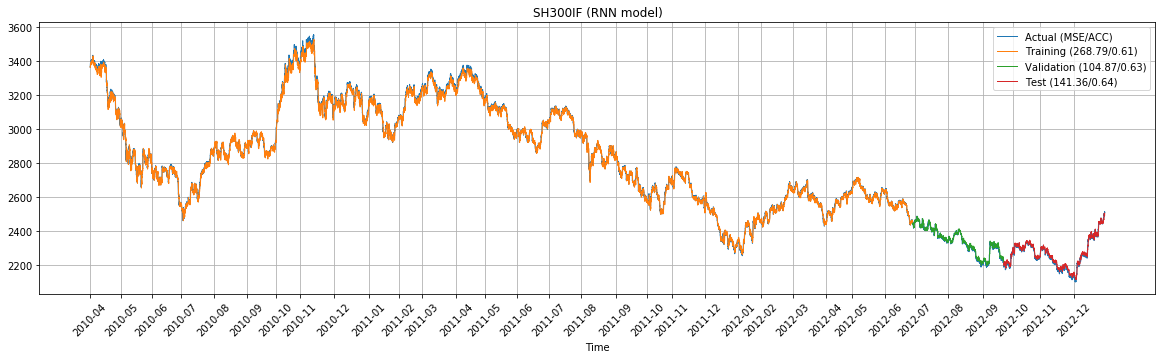

In [14]:
# Plot the results on training, validation and test data sets for Simple RNN model
labels = ['Actual', 'Training', 'Validation', 'Test']
RNN_predictions.plot_predictions(title="SH300IF (RNN model)", labels=labels)

In [15]:
# Create a ModelPredictions object containing results from the GRU model 
GRU_predictions = ModelPredictions(GRU_model, 
                                   X = GRUdata.X, 
                                   y = GRUdata.y, 
                                   raw_y = GRUdata.raw_seq, 
                                   datetime = GRUdata.datetime,
                                   window = GRU_params['window'],
                                   batch_size = GRU_params['batch_size'])

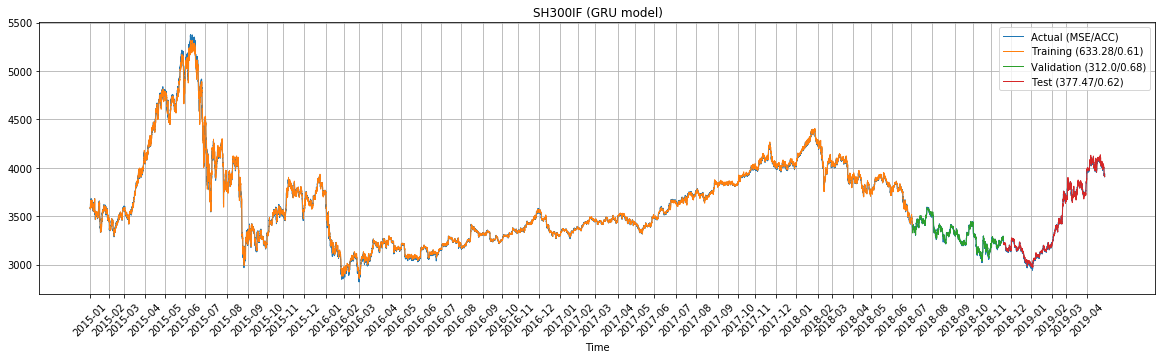

In [16]:
# Plot the results on training, validation and test data sets for RNN-GRU model
labels = ['Actual', 'Training', 'Validation', 'Test']
GRU_predictions.plot_predictions(title="SH300IF (GRU model)", labels=labels)

In [17]:
# Create a ModelPredictions object containing results from the LSTM model 
LSTM_predictions = ModelPredictions(LSTM_model, 
                                    X = LSTMdata.X, 
                                    y = LSTMdata.y, 
                                    raw_y = LSTMdata.raw_seq, 
                                    datetime = LSTMdata.datetime,
                                    window = LSTM_params['window'],
                                    batch_size = LSTM_params['batch_size'])

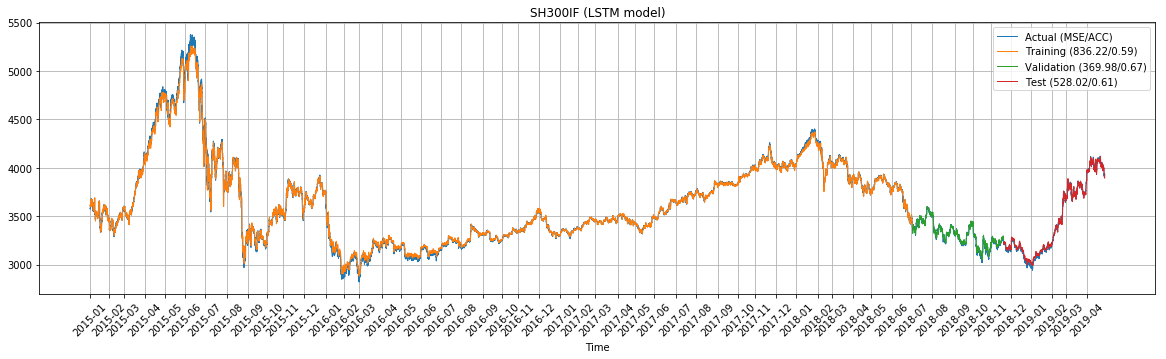

In [18]:
# Plot the results on training, validation and test data sets for RNN-LSTM model
labels = ['Actual', 'Training', 'Validation', 'Test']
LSTM_predictions.plot_predictions(title="SH300IF (LSTM model)", labels=labels)

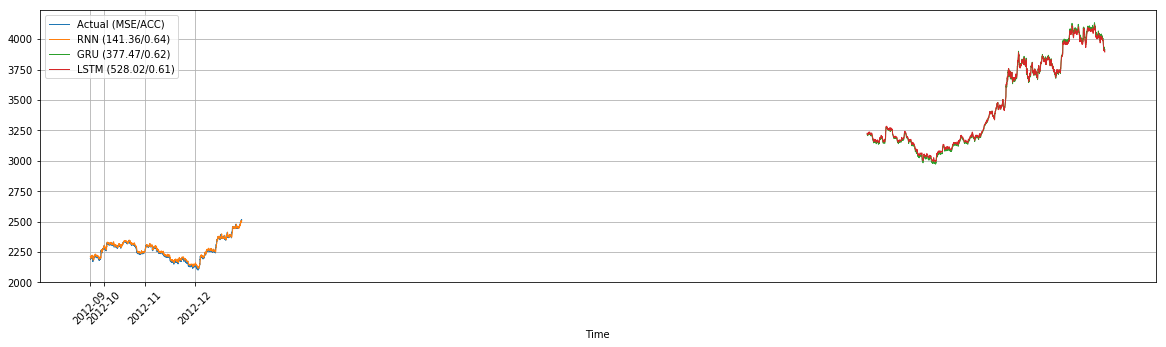

In [19]:
# Plot and compare the results obtained from the three RNNs on the test data set
testset = [RNN_predictions.true_org[2], 
           RNN_predictions.predictions_org[2],
           GRU_predictions.predictions_org[2],
           LSTM_predictions.predictions_org[2]]
datetime = pd.Series(RNNdata.datetime[2].values, 
                     index = RNN_predictions.true_org[2].index)
labels = ['Actual', 'RNN', 'GRU', 'LSTM']
mse = [RNN_predictions.loss[2],
       GRU_predictions.loss[2],
       LSTM_predictions.loss[2]]
mda = [RNN_predictions.mda[2],
       GRU_predictions.mda[2],
       LSTM_predictions.mda[2]]
labels_loss = create_labels(labels, mse, mda)
plot_seqs(testset, datetime=datetime, labels=labels_loss)

In [20]:
# Load previously saved models, including architecture, weights and optimizer states
dependencies = {'rmse': rmse,
                'mda': mda}
saved_RNN = load_model(OUTPUT_PATH, custom_objects=dependencies)

ValueError: When passing a list of lists as `metrics`, it should have one entry per model output. The model has 1 outputs, but you passed metrics=[<function rmse at 0x7fe77b93e378>, [0.6390977443609023, 0.6220095693779905, 0.6100478468899522]]

In [21]:
# Create a StockIndexDataset object that contains new data for testing the SimpleRNN network
# Create the object with the key "test_only=True"

test_data = StockIndexDataset(datasets_path[-1], time_steps=RNN_params['time_steps'], 
                              forecast_steps=RNN_params['forecast_steps'],
                              batch_size=RNN_params['batch_size'], test_only=True)
test_data.info()

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Test Set Length: (27040, 1)


In [22]:
# Create a ModelPredictions object containing results of the Simple RNN model on the test data set 
RNN_test = ModelPredictions(saved_RNN, 
                            X = test_data.X, 
                            y = test_data.y, 
                            raw_y = test_data.raw_seq, 
                            datetime = test_data.datetime,
                            window = RNN_params['window'],
                            batch_size = RNN_params['batch_size'])

NameError: name 'saved_RNN' is not defined

In [23]:
# Plot the testing results
labels = ['Actual', 'Test']
RNN_test.plot_predictions(title="SH300IF (RNN model)", labels=labels)

NameError: name 'RNN_test' is not defined